# Notebook 2

#### This notebook is used for doing text analysis and sentiment analysis on the megathreads and posts from job sections of Reddit. 

In [1]:
import praw
import re
import collections
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

import torch
import transformers
from transformers import pipeline


nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download("stopwords")
nltk.download("vader_lexicon")

import os
from tqdm import tqdm

import time
from datetime import datetime, timedelta, timezone

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

[nltk_data] Downloading package punkt to /Users/jacky/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/jacky/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/jacky/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jacky/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
print(sent_tokenize("Hello! How are you? This is an NLTK test."))

['Hello!', 'How are you?', 'This is an NLTK test.']


## Preparation

In [3]:
reddit = praw.Reddit(
    client_id="Pb_1-TscU4Aza0JxUKT_KA",
    client_secret="NO-4Zv8W-Jun6cEEWpUpCkVX7Wq9gg",
    user_agent="Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/133.0.0.0 Safari/537.36",
    ratelimit_seconds=180
)

subreddit = reddit.subreddit("jobs")

Version 7.7.1 of praw is outdated. Version 7.8.1 was released Friday October 25, 2024.


In [4]:
for post in subreddit.hot(limit=5):
    print(f"\n🔥 Post Title: {post.title} (Upvotes: {post.score})")
    print(f"🔗 URL: {post.url}")


🔥 Post Title: Success and Disappointment Megathread for the Week (Upvotes: 51)
🔗 URL: https://www.reddit.com/r/jobs/comments/1dse341/success_and_disappointment_megathread_for_the_week/

🔥 Post Title: Success and Disappointment Megathread for the Week (Upvotes: 2)
🔗 URL: https://www.reddit.com/r/jobs/comments/1j25eey/success_and_disappointment_megathread_for_the_week/

🔥 Post Title: Lost a Job then Got a JOB Yesterday! (Upvotes: 28)
🔗 URL: https://www.reddit.com/r/jobs/comments/1j7ea4l/lost_a_job_then_got_a_job_yesterday/

🔥 Post Title: I'm considering quitting after my first day (Upvotes: 21)
🔗 URL: https://www.reddit.com/r/jobs/comments/1j7g37f/im_considering_quitting_after_my_first_day/

🔥 Post Title: Gave notice, got fired (Upvotes: 1145)
🔗 URL: https://www.reddit.com/r/jobs/comments/1j6slqn/gave_notice_got_fired/


In [5]:
sentiment_pipeline = pipeline("sentiment-analysis")
text = "I hate this product! But it's good."
print(sentiment_pipeline(text))

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


[{'label': 'POSITIVE', 'score': 0.9998650550842285}]


## Analysis of keywords from current hot posts to see job seekers' current experience.

In [6]:
hot_posts = subreddit.hot(limit=1000)
titles = [post.title for post in hot_posts]

In [7]:
len(titles)

694

In [8]:
for i, title in enumerate(titles[:10]):
    print(title)

Success and Disappointment Megathread for the Week
Success and Disappointment Megathread for the Week
Lost a Job then Got a JOB Yesterday!
I'm considering quitting after my first day
Gave notice, got fired
Roast my resume: 0 interviews, 0 replies, 0 response
I hate applying for jobs
Recruiters are the most useless people on earth
Employer threatens to fire me for updating my resume
I might be too stupid for jobs that pay a livable wage. Advice needed.


In [9]:
stop_words = set(stopwords.words("english"))

In [10]:
def preprocess_text(text):
    text = text.lower()  # 1. 转换为小写
    text = re.sub(r"[^\w\s]", "", text)  # 2. 去除标点符号
    words = text.split()  # 3. 拆分单词（Tokenization）
    words = [word for word in words if word not in stop_words]  # 4. 去除停用词
    return words

In [11]:
processed_titles = [preprocess_text(title) for title in titles]
for i, words in enumerate(processed_titles[:10]):
    print(f"{i+1}. {words}")

1. ['success', 'disappointment', 'megathread', 'week']
2. ['success', 'disappointment', 'megathread', 'week']
3. ['lost', 'job', 'got', 'job', 'yesterday']
4. ['im', 'considering', 'quitting', 'first', 'day']
5. ['gave', 'notice', 'got', 'fired']
6. ['roast', 'resume', '0', 'interviews', '0', 'replies', '0', 'response']
7. ['hate', 'applying', 'jobs']
8. ['recruiters', 'useless', 'people', 'earth']
9. ['employer', 'threatens', 'fire', 'updating', 'resume']
10. ['might', 'stupid', 'jobs', 'pay', 'livable', 'wage', 'advice', 'needed']


In [12]:
flattened_words = [word for title in processed_titles for word in title]
word_counts = collections.Counter(flattened_words)

In [13]:
df_freq = pd.DataFrame(word_counts.most_common(20), columns=["Word", "Frequency"])
df_freq.head(10)

,Word,Frequency
0,job,212
1,interview,54
2,work,46
3,advice,45
4,jobs,42
5,im,33
6,need,31
7,get,31
8,got,30
9,resume,30


Now we can see there are lots of words that do not provide any emotion or bias information in them. Therefore we want to further filter out those words with clear emotions to see the meaningful words distributions.

In [14]:
sia = SentimentIntensityAnalyzer()

sentiment_words = [
    (word, count, sia.polarity_scores(word)["compound"])
    for word, count in word_counts.items()
    if abs(sia.polarity_scores(word)["compound"]) > 0.2  # 过滤掉中性词
]

In [15]:
sorted_sentiment_words = sorted(sentiment_words, key=lambda x: abs(x[2]), reverse=True)
df_sentiment = pd.DataFrame(sorted_sentiment_words, columns=["Word", "Frequency", "Sentiment Score"])

In [16]:
df_high_freq = df_sentiment[df_sentiment["Frequency"] > 1]
df_high_freq_sorted = df_high_freq.sort_values(by="Frequency", ascending=False)
df_high_freq_sorted.head(20)


,Word,Frequency,Sentiment Score
101,help,18,0.4019
125,like,13,0.3612
15,fired,13,-0.5574
67,good,12,0.4404
192,worth,12,0.2263
2,best,11,0.6369
28,rejected,10,-0.5106
17,bad,9,-0.5423
150,lost,7,-0.3182
49,wrong,7,-0.4767


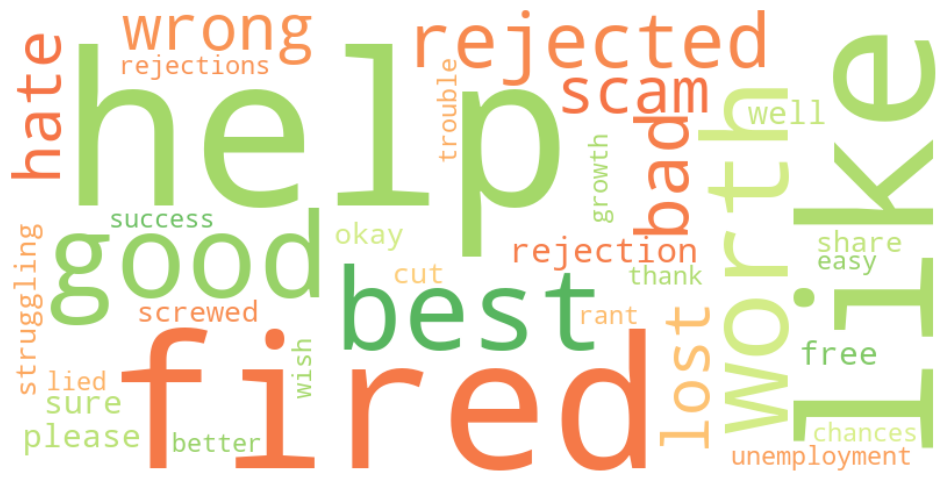

In [20]:
filtered_words = df_high_freq.set_index("Word")["Frequency"].to_dict()
word_sentiments = df_high_freq.set_index("Word")["Sentiment Score"].to_dict()

def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    sentiment = word_sentiments[word]  # 获取单词的情感分数
    cmap = plt.get_cmap("RdYlGn")  # 负面（红）→ 中性（黄）→ 正面（绿）
    norm_sentiment = (sentiment + 1) / 2  # 将情感分数归一化到 0~1
    r, g, b, _ = cmap(norm_sentiment)  # 取色
    return f"rgb({int(r*255)}, {int(g*255)}, {int(b*255)})"

# 生成词云
wordcloud = WordCloud(
    width=800, height=400,
    background_color="white",
    prefer_horizontal=0.8,
    color_func=color_func  # 使用自定义颜色映射
).generate_from_frequencies(filtered_words)

# 显示词云
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

/var/folders/hw/l210v46d55793g9ypyh13bvh0000gn/T/ipykernel_22550/816605542.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Word", y="positive_frequency", data=df_high_freq_sorted, palette=df_high_freq_sorted["color"].to_list())


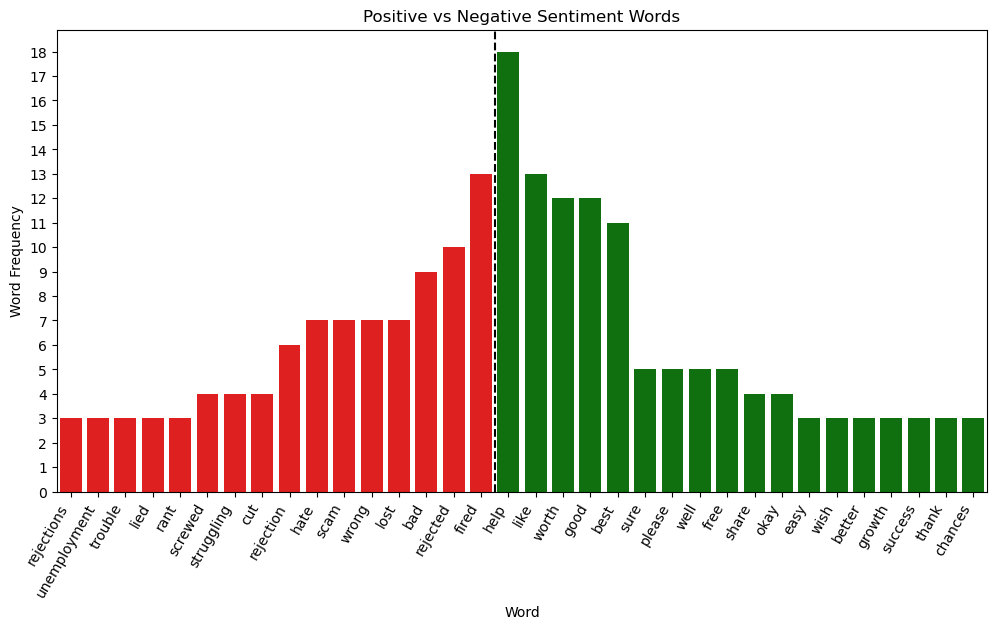

In [18]:
# 只保留出现次数大于 2 的词
df_high_freq = df_sentiment[df_sentiment["Frequency"] > 2].copy()

# 设置颜色：正面（绿）负面（红）
df_high_freq["color"] = df_high_freq["Sentiment Score"].apply(lambda x: "green" if x > 0 else "red")

# 让所有的频率变正
df_high_freq["positive_frequency"] = df_high_freq["Frequency"]

# **负面词按词频降序排列，正面词也按词频降序排列**
df_negative = df_high_freq[df_high_freq["Sentiment Score"] < 0].sort_values(by="Frequency", ascending=True)
df_positive = df_high_freq[df_high_freq["Sentiment Score"] > 0].sort_values(by="Frequency", ascending=False)

# **合并负面词和正面词，使高频词靠近黑线**
df_high_freq_sorted = pd.concat([df_negative, df_positive])

# 设置图形
plt.figure(figsize=(12, 6))

# 绘制柱状图
sns.barplot(x="Word", y="positive_frequency", data=df_high_freq_sorted, palette=df_high_freq_sorted["color"].to_list())

# **添加黑色虚线（负面词和正面词之间）**
num_negative = len(df_negative)
plt.axvline(num_negative - 0.5, color="black", linestyle="--")  

# **将 Y 轴坐标设置为整数**
plt.yticks(np.arange(0, df_high_freq_sorted["positive_frequency"].max() + 1, step=1))

# 美化
plt.ylabel("Word Frequency")  # 频率在 Y 轴
plt.xlabel("Word")  # 词语在 X 轴
plt.title("Positive vs Negative Sentiment Words")
plt.xticks(rotation=60, ha="right")  # 旋转 X 轴标签，避免重叠
plt.show()


## Analysis of comments from megathreads under jobs section to see the historical trending.

### 2025

In [6]:
post_id = "1dse341"

submission = reddit.submission(id=post_id)

submission.comments.replace_more(limit=None)

all_comments = submission.comments.list()

for idx, comment in enumerate(all_comments[:5], 1):
    print(f"{idx}. {comment.body[:30]}...") 


1. After months of being rejected...
2. Got caught off guard with a ca...
3. I am stuck in a $20.50/hr vide...
4. Separated from my last job at ...
5. Disappointment: 

I had a prom...


In [7]:
def get_2025_megathread_ids():
    reddit = praw.Reddit(
        client_id="Pb_1-TscU4Aza0JxUKT_KA",
        client_secret="NO-4Zv8W-Jun6cEEWpUpCkVX7Wq9gg",
        user_agent="Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/133.0.0.0 Safari/537.36",
        ratelimit_seconds=180
    )

    subreddit = reddit.subreddit("jobs")
    search_query = "Success and Disappointment Megathread for the Week"
    
    post_ids = []
    
    for submission in subreddit.search(search_query, time_filter="year", sort="new", limit=100):
        if submission.title == "Success and Disappointment Megathread for the Week":
            post_ids.append(submission.id)

    return post_ids


In [8]:
megathread_ids_2025 = get_2025_megathread_ids()
print(megathread_ids_2025)

['1j25eey', '1iwogln', '1ir6h4p', '1ilt1q4', '1igbnmr', '1iaugas', '1i5d1hy', '1i00vey', '1huldcn', '1hp9pch', '1hkb90t', '1hf62ii']


In [9]:
def get_comments_from_id(post_id):
    try:
        reddit = praw.Reddit(
            client_id="Pb_1-TscU4Aza0JxUKT_KA",
            client_secret="NO-4Zv8W-Jun6cEEWpUpCkVX7Wq9gg",
            user_agent="Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/133.0.0.0 Safari/537.36",
            ratelimit_seconds=180
        )

        submission = reddit.submission(id=post_id)
        submission.comments.replace_more(limit=None)
        all_comments = submission.comments.list()

        filtered_comments = [comment.body for comment in all_comments if len(comment.body) < 500]

        sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
        
        analyzed_comments = [
            {"comment": comment, "sentiment": sentiment_analyzer(comment)[0]} 
            for comment in filtered_comments
        ]
        
        return analyzed_comments
    
    except:
        return[]

In [10]:
def aggregate_sentiments(id_list):
    sentiment_counts = Counter()
    
    for post_id in tqdm(id_list, desc="Processing posts", unit="post"):
        analyzed_comments = get_comments_from_id(post_id)
        for analyzed_comment in analyzed_comments:
            sentiment = analyzed_comment.get("sentiment").get("label")
            sentiment_counts[sentiment] += 1
    
    return sentiment_counts

In [11]:
sentiment_result = aggregate_sentiments(megathread_ids_2025)
sentiment_result

Processing posts:   0%|          | 0/12 [00:00<?, ?post/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Processing posts:   8%|▊         | 1/12 [00:22<04:09, 22.70s/post]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use mps:0
Processing posts: 100%|██████████| 12/12 [00:33<00:00,  2.77s/post]


Counter({'NEGATIVE': 39, 'POSITIVE': 23})

In [ ]:
labels = list(sentiment_result.keys())  # ['NEGATIVE', 'POSITIVE']
values = list(sentiment_result.values())  # [39, 23]

fig = px.pie(
    names=labels, 
    values=values, 
    title="Sentiment Analysis Distribution",
    color=labels,
    color_discrete_map={"NEGATIVE": "red", "POSITIVE": "green"}
)

fig.update_traces(textinfo="percent+label")
fig.update_layout(
    title_x=0.5,  # 标题居中
    showlegend=False  # 隐藏侧边图例
)

fig.show()

### 2024

In [ ]:
def get_2024_megathread_ids():
    reddit = praw.Reddit(
        client_id="Pb_1-TscU4Aza0JxUKT_KA",
        client_secret="NO-4Zv8W-Jun6cEEWpUpCkVX7Wq9gg",
        user_agent="Mozilla/5.0"
    )

    subreddit = reddit.subreddit("jobs")
    search_query = "megathread"

    start_of_last_year = int(datetime(2024, 1, 1, tzinfo=timezone.utc).timestamp())
    end_of_last_year = int(datetime(2024, 12, 31, 23, 59, 59, tzinfo=timezone.utc).timestamp())

    post_ids = []

    for submission in subreddit.search(search_query, sort="new", limit=100):
        post_time = int(submission.created_utc)
        
        if start_of_last_year <= post_time <= end_of_last_year:
            post_ids.append(submission.id)

    return post_ids

In [12]:
megathread_ids_2024 = get_2024_megathread_ids()
print(megathread_ids_2024)

['1hp9pch', '1hkb90t', '1hhl3na', '1hf62ii', '1h9wkzo', '1h4hhsa', '1gz5fsn', '1gtrhkc', '1goetfl', '1gj14vd', '1gdoyvf', '1g8bjn1', '1g326m9', '1fxtdcd', '1fsh867', '1fn653e', '1fhprpr', '1fcatmb', '1f6rqdc', '1f19f7i', '1evmlox', '1epy3rm', '1ek8ifa', '1eekavr', '1e8z4zt', '1e3fim6', '1dxtkm4', '1dse341', '1dmyrkh', '1dhjqqt', '1dc6tww', '1d6px57', '1d1dkf8', '1cw0wdj', '1cqkj8f', '1cl42xp', '1cfjshj', '1c9vemu', '1c46w41', '1byi5zf', '1bsnoqn', '1bmzmy8', '1bhcviv', '1bbp7r7', '1b5wc20', '1b038ei', '1au932s', '1aomgtt', '1aj2lex', '1adh7bq', '19chv5e', '196ueeo', '1916tfq', '18vkh2q']


In [13]:
sentiment_result = aggregate_sentiments(megathread_ids_2024)
sentiment_result

Processing posts:   0%|          | 0/54 [00:00<?, ?post/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Device set to use mps:0
Processing posts: 100%|██████████| 54/54 [01:12<00:00,  1.34s/post]


Counter({'NEGATIVE': 1132, 'POSITIVE': 473})

In [14]:
labels = list(sentiment_result.keys())  # ['NEGATIVE', 'POSITIVE']
values = list(sentiment_result.values())  # [39, 23]

fig = px.pie(
    names=labels, 
    values=values, 
    title="Sentiment Analysis Distribution",
    color=labels,
    color_discrete_map={"NEGATIVE": "red", "POSITIVE": "green"}
)

fig.update_traces(textinfo="percent+label")
fig.update_layout(
    title_x=0.5,  # 标题居中
    showlegend=False  # 隐藏侧边图例
)

fig.show()

### 2023

In [15]:
def get_2023_megathread_ids():
    reddit = praw.Reddit(
        client_id="Pb_1-TscU4Aza0JxUKT_KA",
        client_secret="NO-4Zv8W-Jun6cEEWpUpCkVX7Wq9gg",
        user_agent="Mozilla/5.0"
    )

    subreddit = reddit.subreddit("jobs")
    search_query = "megathread"

    start_of_last_year = int(datetime(2023, 1, 1, tzinfo=timezone.utc).timestamp())
    end_of_last_year = int(datetime(2023, 12, 31, 23, 59, 59, tzinfo=timezone.utc).timestamp())

    post_ids = []

    for submission in subreddit.search(search_query, sort="new", limit=100):
        post_time = int(submission.created_utc)  # 确保转换为整数
        
        if start_of_last_year <= post_time <= end_of_last_year:
            post_ids.append(submission.id)

    return post_ids

In [16]:
megathread_ids_2023 = get_2023_megathread_ids()
print(megathread_ids_2023)

['18q72my', '18kv3vu', '18fh64e', '18a780h', '184p0y6', '17zayv1', '17txnke', '17opm2v', '17jgdjs', '17e5umu', '178rkxd', '173clz4', '16xfv9i', '16rblwu', '16lexpu', '16feo1o', '169b5fo', '1635053', '15wpuxj', '15qd2s9', '15k3dew', '15dz9yu', '157t47o', '151kgd6', '14vcn6c', '14p1yio', '14j0594', '14cxvd2', '140tome', '13uds3o', '13o963r', '13hq6wx', '13b5xqb', '1345p0i', '12wtmc4', '12osgn9', '12gywx2']


In [17]:
sentiment_result = aggregate_sentiments(megathread_ids_2023)
sentiment_result

Processing posts: 100%|██████████| 37/37 [00:51<00:00,  1.40s/post]


Counter({'NEGATIVE': 959, 'POSITIVE': 446})

In [18]:
labels = list(sentiment_result.keys())  # ['NEGATIVE', 'POSITIVE']
values = list(sentiment_result.values())  # [39, 23]

fig = px.pie(
    names=labels, 
    values=values, 
    title="Sentiment Analysis Distribution",
    color=labels,
    color_discrete_map={"NEGATIVE": "red", "POSITIVE": "green"}
)

fig.update_traces(textinfo="percent+label")
fig.update_layout(
    title_x=0.5,  # 标题居中
    showlegend=False  # 隐藏侧边图例
)

fig.show()